In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *

from scipy.stats import norm



module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
NPOINTS = 13
MULT_UB = 3
MULT_LB = 1

In [3]:
# load Latin Hypercube Sampling results; change to the directory on your machine
lhs_output_sim_files = []
for i in range(2000):
    #fname = '/home/jmc678/covid_data/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    fname = '/home/yz685/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)

scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)
centre = get_centre_point()


The following function computes the new pessimistic configuration from the hyperplane calculation. It returns $\gamma$ and $x_{pess}$.

$$
\gamma = 1.645 \frac{\sqrt{c^T\Sigma c}\sqrt{c^T\Sigma^3c}}{c^T\Sigma^2c} 
= 1.645\frac{\sqrt{\sum_ic_i^2\sigma_i^2}{\sqrt{\sum_ic_i^2\sigma_i^6}}}{\sum_ic_i^2\sigma_i^4}.
$$

$$
x_{pess} = \mu +  1.645 \frac{\sqrt{c^T\Sigma c}\sqrt{c^T\Sigma^3c}}{c^T\Sigma^2c}\frac{\Sigma c}{\sqrt{c^T\Sigma c}} = \mu +  1.645 \frac{\sqrt{c^T\Sigma^3c}\Sigma c}{c^T\Sigma^2c}.
$$

One can directly compare $\gamma$ with 1.96 to see how differently the two pessimistic configurations proceed in the pessimistic direction.

The size of $\Sigma$ is proportional to the ranges $[LB, UB]$ we defined. Note that though the powers of $\Sigma$ cancel out in $\gamma$, i.e., we can use the range widths (or half-widths) as a proxy when calculating $\gamma$, the pessimistic direction vector $\frac{\Sigma c}{\sqrt{c^T\Sigma c}}$ does depend on the absolute size of $\Sigma$, and therefore depends on our assumption about the number of standard deviations in $[LB, UB]$.

In [4]:
# compute c and Sigma c

# should we add a constant dimension when doing the projection?  I think no, but maybe it makes sense
params = list(set(res_results.params.keys()) - set(['const']))

sd_dict = dict()
for param in params:
    sd_dict[param] = (PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0])/(2*1.96)

sigma = np.array([sd_dict[param] for param in params])
Sigma_c = np.array([res_results.params[param] * sd_dict[param]**2 for param in params])
c = np.array([res_results.params[param] for param in params])
mu = np.array([centre[param] for param in params])

In [5]:
# compute orthogonal projection matrix

c_tilde = c / np.linalg.norm(c)

c_tilde_Sigma_c = sum([c_tilde[i] * sigma[i] **2 * c[i] for i in range(12)])

d = Sigma_c - c_tilde_Sigma_c * c_tilde

d_tilde = d/np.linalg.norm(d)

In [6]:
B = np.matrix([ d_tilde, c_tilde])

In [7]:
B.shape

(2, 12)

In [8]:
mu.shape

(12,)

In [9]:
mu.reshape(12,1)

array([[ 2.5 ],
       [ 0.36],
       [ 1.5 ],
       [12.  ],
       [ 0.1 ],
       [ 3.  ],
       [ 2.  ],
       [ 1.  ],
       [ 0.6 ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ]])

In [10]:
new_mu = np.array(B * mu.reshape(12,1))
Sigma = np.diag([sigma[i]**2 for i in range(12)])
new_Sigma = B * Sigma * B.T

In [11]:
new_mu

array([[ 2.52508167],
       [-0.20688908]])

In [37]:
from scipy.stats import multivariate_normal

rv = multivariate_normal(new_mu.reshape(2,), new_Sigma)

x_scale = 1.5
x_array = np.array([new_mu[0] + x_scale * grid_point for grid_point in np.linspace(-1,1,101)])

y_scale = 1
y_array = np.array([new_mu[1] + y_scale * grid_point for grid_point in np.linspace(-1,1,101)])

X,Y = np.meshgrid(x_array, y_array)

pos = np.dstack((X,Y))
Z = rv.pdf(pos)
#Z=rv.cdf(pos)

$y_{pess} = \mu + \Phi^{-1}(q)\frac{\Sigma c}{\sqrt{c^T\Sigma c}} = \mu + \Phi^{-1}(q) \frac{\|\Sigma c\|_2}{\sqrt{c^T\Sigma c}} \frac{\Sigma c}{\|\Sigma c\|_2}=\mu + \Phi^{-1}(q) \frac{\|\Sigma c\|_2}{\sqrt{c^T\Sigma c}} \cdot proj\_Sigma\_c$

In [38]:
proj_c_tilde = B * c_tilde.reshape(12,1)
proj_Sigma_c = B * Sigma_c.reshape(12,1) / np.linalg.norm(Sigma_c)
Sigma_c_slope = proj_Sigma_c[1][0,0] / proj_Sigma_c[0][0,0]


c_Sigma_c = sum([c_tilde[i] * sigma[i] **2 * c[i] for i in range(12)]) * np.linalg.norm(c)
q=0.99
pess_mult = norm.ppf(q)*np.linalg.norm(Sigma_c)/np.sqrt(c_Sigma_c)


pess_point = new_mu + pess_mult * proj_Sigma_c

In [51]:
pess_point=np.array(pess_point).reshape(2,)
pess_point

array([3.74533982, 0.16342321])

In [52]:
rv.pdf(pess_point)
# this is the bivariate normal density at the pessimistic point

0.13035419629916686

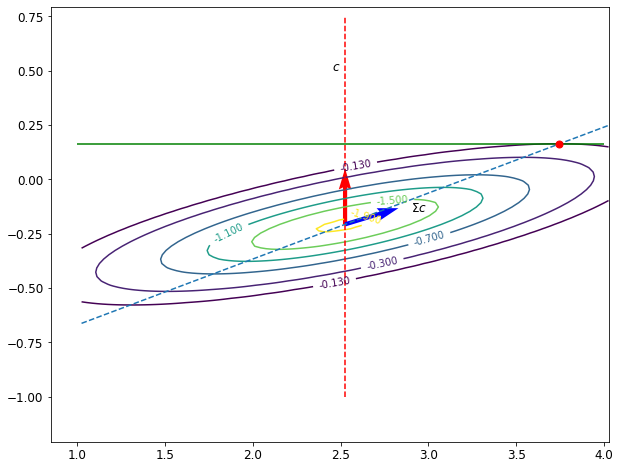

In [59]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10,8))


levels = [rv.pdf(pess_point), 0.3, 0.7, 1.1, 1.5, 1.9]


CS = plt.contour(X, Y, Z, levels=levels)
fmt_func = lambda x,pos: "{:1.3f}".format(-x) # replace by function mapping density to cumulative density



plt.clabel(CS, inline=1, fontsize=10, fmt=FuncFormatter(fmt_func))


mult = 0.1
plt.quiver([new_mu[0]] * 2, [new_mu[1]] * 2, [mult * proj_c_tilde[0][0,0], mult * proj_Sigma_c[0][0,0]], 
           [mult * proj_c_tilde[1][0,0], mult * proj_Sigma_c[1][0,0]],color=['r','b'], scale=1, scale_units='width')
plt.plot(x_array, Sigma_c_slope*(x_array-new_mu[0])+new_mu[1], '--')
plt.vlines(new_mu[0], -1, 0.75, 'r', '--')
plt.hlines(pess_point[1], 1, 4, 'g')
plt.annotate(r'$c$', (2.45, 0.5))
plt.annotate(r'$\Sigma c$', (2.9, -0.15))



plt.plot([pess_point[0]], [pess_point[1]], marker='o', markersize=7, color="red")


# TODO: Ideally, we would want the contours to be labeled with cumulative density values;

plt.show()

In [58]:
proj_c_tilde = B * c_tilde.reshape(12,1)

In [26]:
proj_Sigma_c = B * Sigma_c.reshape(12,1) / np.linalg.norm(Sigma_c)

In [68]:
proj_c_tilde

matrix([[1.00000000e+00],
        [5.89805982e-17]])

In [69]:
proj_Sigma_c

matrix([[0.29039313],
        [0.95690743]])

In [ ]:
params_order

In [4]:
def calculate_pessimistic_scenario_hyperplane(results, q=0.95, beta=1.96):
    # the keys in dict(results.params) specify whether this is for residential
    # or virtual vs. residential
    lr_results = dict(results.params)
    sd_dict = dict()
    pess_direction = dict()
    params = set(lr_results.keys()) - set(['const'])
    centre_infections = lr_results['const']
    
    invquantile = norm.ppf(q)
    
    for param in params:
        sd_dict[param] = (PARAM_BOUNDS[param][1] - PARAM_BOUNDS[param][0])/(2*beta)
        centre_infections += np.mean(PARAM_BOUNDS[param]) * lr_results[param]
    
    sum_squares_Sigma_1 = 0
    sum_squares_Sigma_2 = 0
    sum_squares_Sigma_3 = 0
    
    for param in params:
        sum_squares_Sigma_1 += (lr_results[param]*sd_dict[param]) ** 2
        sum_squares_Sigma_2 += (lr_results[param]* sd_dict[param]**2) ** 2
        sum_squares_Sigma_3 += (lr_results[param]* sd_dict[param]**3) ** 2
    
    gamma = invquantile * np.sqrt(sum_squares_Sigma_1 * sum_squares_Sigma_3) / sum_squares_Sigma_2
    
    print('square root of c^T Sigma c = {}'.format(np.sqrt(sum_squares_Sigma_1)))
    
    for param in params:
        pess_direction[param] = lr_results[param]*(sd_dict[param])**2 / np.sqrt(sum_squares_Sigma_1)
    print('pessimistic direction {}'.format(pess_direction))
    
    
    # calculate pessimistic scenario based on available params
    pess_scenario = dict()
    old_pess_scenario = dict()
    
    # @Alyf see here: pessimistic scenario from magic paragraph
    mp_pess_scenario = dict()
    for param in params:
        pess_scenario[param] = np.mean(PARAM_BOUNDS[param]) + gamma * pess_direction[param]
        old_pess_scenario[param] = np.mean(PARAM_BOUNDS[param]) + beta * pess_direction[param]
        mp_pess_scenario[param] = np.mean(PARAM_BOUNDS[param]) + invquantile * pess_direction[param]
    
    # add default virtual params if not present
    default_virtual_param_vals = {param:(PARAM_BOUNDS[param][1] + PARAM_BOUNDS[param][0])/2 for param in ADDITIONAL_VIRTUAL_PARAMS}
    for virtual_param, val in default_virtual_param_vals.items():
        if virtual_param not in params:
            pess_scenario[virtual_param] = val

    return gamma, pess_direction, mp_pess_scenario, pess_scenario, old_pess_scenario, centre_infections, np.sqrt(sum_squares_Sigma_1)

In [5]:
gamma, pess_direction, mp_pess, new_pess, old_pess, centre_infections, sqrt_csc = calculate_pessimistic_scenario_hyperplane(res_results)

square root of c^T Sigma c = 457.90949409819103
pessimistic direction {'Sy_time': -0.0012947192984487984, 'R0': 0.5232711930770081, 'ID_time': 0.051102142940969236, 'test_sensitivity': -0.040285520207408304, 'ct_testing_ratio': -0.08117944214759011, 'daily_self_report_prob': -0.006941788198258758, 'test_noncompliance': 0.002637356803922309, 'asymp_prob_mult': 0.07765805188268869, 'ct_mult': -0.09375898267056981, 'inital_prev_mult': 0.026212744870253674, 'outside_inf_mult': 0.012315513821857017, 'E_time': -0.01117046688015883}


In [6]:
# Pessmistic scenario from June 22 calculation (magic paragraph)
mp_pess

{'Sy_time': 11.997870376266063,
 'R0': 3.3607045198119407,
 'ID_time': 3.084055545161446,
 'test_sensitivity': 0.5337362159732177,
 'ct_testing_ratio': 0.8664717001496391,
 'daily_self_report_prob': 0.3485817745045651,
 'test_noncompliance': 0.10433806590449676,
 'asymp_prob_mult': 1.1277361283012262,
 'ct_mult': 1.345780197295033,
 'inital_prev_mult': 1.0431161284721904,
 'outside_inf_mult': 1.0202572175776525,
 'E_time': 1.9816262170374295}

In [7]:
# print and compare current pessimistic value and new pessimistic value

print ("{:<30} {:<30} {:<30} {:<30}".format('PARAMETER', 'Old_Pess (mult=1.96)', 'Halfspace_Pess (mult=2.21)', 'MP_Pess (mult=1.645)'))
  
for param, old_pess_value in old_pess.items():
    print ("{:<30} {:<30} {:<30} {:<30}".format(param, old_pess_value, new_pess[param], mp_pess[param]))

PARAMETER                      Old_Pess (mult=1.96)           Halfspace_Pess (mult=2.21)     MP_Pess (mult=1.645)          
Sy_time                        11.99746235017504              11.997142688574325             11.997870376266063            
R0                             3.525611538430936              3.6548053392710704             3.3607045198119407            
ID_time                        3.1001602001642996             3.1127771379299682             3.084055545161446             
test_sensitivity               0.5210403803934798             0.5110940283999521             0.5337362159732177            
ct_testing_ratio               0.8408882933907234             0.8208453771746467             0.8664717001496391            
daily_self_report_prob         0.34639409513141284            0.34468019225690805            0.3485817745045651            
test_noncompliance             0.10516921933568774            0.10582037337240568            0.10433806590449676           
asymp_pr

In [11]:
lr_results = dict(res_results.params)
params = set(lr_results.keys()) - set(['const'])

c_sq_norm = 0
pessdir_sq_norm = 0
dot_prod = 0

for param in params:
    c_sq_norm += lr_results[param]**2
    pessdir_sq_norm += pess_direction[param]**2
    dot_prod += lr_results[param] * pess_direction[param]
    print(lr_results[param] * pess_direction[param], param)

c_norm = np.sqrt(c_sq_norm)
pessdir_norm = np.sqrt(pessdir_sq_norm)

cosine = dot_prod / (c_norm * pessdir_norm)

1.0672271230385169 outside_inf_mult
0.0029487844905898442 Sy_time
71.37230974915639 test_sensitivity
46.37072726658484 ct_testing_ratio
4.593778128051371 ID_time
214.07350820235644 R0
4.894288431536393 test_noncompliance
4.324923568830988 daily_self_report_prob
4.834780737833667 inital_prev_mult
44.30011137205822 asymp_prob_mult
61.85539077634875 ct_mult
0.2194999579049594 E_time


In [9]:
cosine

0.2903931304473415

In [30]:
centre_infections

419.58972196656873

In [32]:



alphas = np.linspace(0.01, 0.99, num=99)


quantiles = []
pess_infections = []

for alpha in alphas:
    invcdf_alpha = norm.ppf(alpha)
    
    quantile_alpha = centre_infections + invcdf_alpha * sqrt_csc
    pess_infection_alpha = centre_infections + invcdf_alpha * sqrt_csc * 1.34
    
    quantiles.append(quantile_alpha)
    pess_infections.append(pess_infection_alpha)

In [47]:
quantiles[-1], pess_infections[-1]

(2507.4930070395185, 3217.3801239643217)

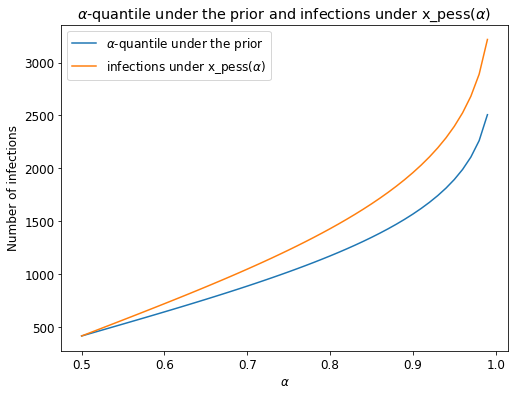

In [44]:
plt.figure(figsize=(8,6))
plt.plot(alphas[49:], quantiles[49:], label=r'$\alpha$-quantile under the prior')
plt.plot(alphas[49:], pess_infections[49:], label=r'infections under x_pess($\alpha$)')
plt.title(r'$\alpha$-quantile under the prior and infections under x_pess($\alpha$)')
plt.xlabel(r'$\alpha$')
plt.ylabel('Number of infections')
plt.legend()

In [6]:
# compare this to 1.96 (old)
gamma

2.207092840079398

Now we print the new_pess and old_pess values;
we can confirm the old_pess align with the ones computed using the old calculate_pessimistic_scenario(), which justifies including beta as a parameter

In [15]:
# print and compare current pessimistic value and new pessimistic value

print ("{:<30} {:<30} {:<30} {:<30}".format('PARAMETER', 'Old_Pess (old_gamma=1.96)', 'New_Pess (new_gamma=2.21)', 'Pessimistic_direction'))
  
for param, old_pess_value in old_pess.items():
    print ("{:<30} {:<30} {:<30} {:<30}".format(param, old_pess_value, new_pess[param], pess_direction[param]))

PARAMETER                      Old_Pess (old_gamma=1.96)      New_Pess (new_gamma=2.21)      Pessimistic_direction         
ID_time                        3.1001602001642996             3.1127871737977273             0.05110214294096922           
ct_mult                        1.3162323939656833             1.2930652206546571             -0.09375898267056981          
R0                             3.525611538430936              3.654908103660069              0.5232711930770082            
outside_inf_mult               1.0241384070908397             1.0271814823781196             0.012315513821857015          
daily_self_report_prob         0.34639409513141284            0.3446788289702754             -0.006941788198258757         
E_time                         1.9781058849148887             1.9753457425284573             -0.011170466880158828         
asymp_prob_mult                1.1522097816900698             1.1713985302847967             0.0776580518826887            
test_sen